In [13]:
import numpy as np

# Parámetros del evento
NUM_ASISTENTES = 6000
CAPACIDAD_PONENCIAS = 300  # Máximo de 300 asistentes por ponencia
CAPACIDAD_LOUNGE = 1500  # Máximo de 1500 asistentes en salas lounge
CAPACIDAD_BAÑO_HOMBRES = 40  # Máximo de 40 asistentes en baño hombres
CAPACIDAD_BAÑO_MUJERES = 40  # Máximo de 40 asistentes en baño mujeres

# Horarios de las ponencias
HORARIOS_PONENCIAS = [(9 * 60 + 10, 9 * 60 + 30), (9 * 60 + 40, 10 * 60)]

# Capacidad y duración de stands
stands = {
    1: {"capacidad": 80, "duracion": 5},
    2: {"capacidad": 80, "duracion": 5},
    3: {"capacidad": 50, "duracion": 5},
    4: {"capacidad": 36, "duracion": 5},
    5: {"capacidad": 20, "duracion": 5},
    6: {"capacidad": 20, "duracion": 5},
    7: {"capacidad": 20, "duracion": 5},
    8: {"capacidad": 20, "duracion": 5},
    9: {"capacidad": 5, "duracion": 2},
    10: {"capacidad": 5, "duracion": 2}
}

# Capacidad y duración de pantallas
pantallas = {
    1: {"capacidad": 5, "duracion": 3},
    2: {"capacidad": 5, "duracion": 3}
}

# Escenarios de permanencia
escenarios_permanencia = {
    "Corta Permanencia": 0.7,
    "Media Permanencia": 0.8,
    "Larga Permanencia": 0.9
}

# Ajuste final: Implementar todas las mejoras
probabilidades_actividades = {
    "Ponencia": 0.1,  # Limitada a 300 asistentes por horario
    "Visita Stand": 0.5,
    "Visita Pantalla": 0.15,
    "Lounge": 0.15,
    "Baño": 0.05,
    "Libre": 0.05  # Ajustada para que la suma sea 1
}

# Verificación de la suma de probabilidades
assert np.isclose(sum(probabilidades_actividades.values()), 1.0), "Las probabilidades no suman 1"

# Almacenar resultados por escenario
asistentes_libres_por_escenario = {}

# Simulación para cada escenario
for escenario, permanencia in escenarios_permanencia.items():
    asistentes_libres = 0
    asistentes_ponencias_horario1 = 0
    asistentes_ponencias_horario2 = 0
    asistentes_lounge = 0
    asistentes_baño_hombres = 0
    asistentes_baño_mujeres = 0
    stands_ocupacion = {i: [] for i in stands.keys()}
    pantallas_ocupacion = {i: [] for i in pantallas.keys()}
    espera_stands = {i: [] for i in stands.keys()}  # Lista de espera para stands
    espera_pantallas = {i: [] for i in pantallas.keys()}  # Lista de espera para pantallas

    for tiempo in range(0, 90, 1):  # Simular minuto a minuto entre 9:00 AM y 10:30 AM
        for _ in range(NUM_ASISTENTES // 90):  # Distribuir asistentes a lo largo del tiempo
            if asistentes_ponencias_horario1 < CAPACIDAD_PONENCIAS and tiempo in range(HORARIOS_PONENCIAS[0][0] - 540, HORARIOS_PONENCIAS[0][1] - 540):
                actividad = "Ponencia_1"
                asistentes_ponencias_horario1 += 1
            elif asistentes_ponencias_horario2 < CAPACIDAD_PONENCIAS and tiempo in range(HORARIOS_PONENCIAS[1][0] - 540, HORARIOS_PONENCIAS[1][1] - 540):
                actividad = "Ponencia_2"
                asistentes_ponencias_horario2 += 1
            else:
                # Intentar encontrar una actividad disponible
                actividad = np.random.choice(list(probabilidades_actividades.keys()), p=list(probabilidades_actividades.values()))
                
                if actividad == "Visita Stand":
                    stand_disponible = next((s for s, datos in stands.items() if len(stands_ocupacion[s]) < datos["capacidad"]), None)
                    if stand_disponible is not None:
                        stands_ocupacion[stand_disponible].append(tiempo + stands[stand_disponible]["duracion"])
                    else:
                        espera_stands[stand_disponible].append(_)  # Poner en espera
                        actividad = "En espera Stand"
                
                elif actividad == "Visita Pantalla":
                    pantalla_disponible = next((p for p, datos in pantallas.items() if len(pantallas_ocupacion[p]) < datos["capacidad"]), None)
                    if pantalla_disponible is not None:
                        pantallas_ocupacion[pantalla_disponible].append(tiempo + pantallas[pantalla_disponible]["duracion"])
                    else:
                        if pantalla_disponible in espera_pantallas:
                            espera_pantallas[pantalla_disponible].append(_)  # Poner en espera
                            actividad = "En espera Pantalla"
                        else:
                            actividad = "Libre"
                
                elif actividad == "Lounge" and asistentes_lounge < CAPACIDAD_LOUNGE:
                    asistentes_lounge += 1
                elif actividad == "Baño":
                    if np.random.rand() < 0.5 and asistentes_baño_hombres < CAPACIDAD_BAÑO_HOMBRES:
                        asistentes_baño_hombres += 1
                    elif asistentes_baño_mujeres < CAPACIDAD_BAÑO_MUJERES:
                        asistentes_baño_mujeres += 1
                    else:
                        actividad = "Libre"
                if actividad == "Libre":
                    asistentes_libres += 1

        # Liberar stands y pantallas después de su duración y asignar a los de la lista de espera
        for s in stands.keys():
            stands_ocupacion[s] = [t for t in stands_ocupacion[s] if t > tiempo]
            while espera_stands[s] and len(stands_ocupacion[s]) < stands[s]["capacidad"]:
                stands_ocupacion[s].append(espera_stands[s].pop(0) + stands[s]["duracion"])

        for p in pantallas.keys():
            pantallas_ocupacion[p] = [t for t in pantallas_ocupacion[p] if t > tiempo]
            while p in espera_pantallas and espera_pantallas[p] and len(pantallas_ocupacion[p]) < pantallas[p]["capacidad"]:
                pantallas_ocupacion[p].append(espera_pantallas[p].pop(0) + pantallas[p]["duracion"])

    # Guardar resultado para el escenario actual
    asistentes_libres_por_escenario[escenario] = asistentes_libres

# Mostrar los resultados
print(asistentes_libres_por_escenario)


{'Corta Permanencia': 1005, 'Media Permanencia': 1038, 'Larga Permanencia': 1033}


-----

# Gráficos sin escenarios

In [ ]:
import matplotlib.pyplot as plt
#import numpy as np

# Datos de la simulación
horas = np.arange(9, 10.5, 0.1)  # De 9:00 AM a 10:30 AM en intervalos de 6 minutos
actividades = ["Ponencias", "Stands", "Pantallas", "Lounge", "Baños", "Libres"]

# Datos simulados de asistentes en cada actividad
np.random.seed(42)
heatmap_data = np.random.randint(50, 500, size=(len(actividades), len(horas)))

# Filtrar las horas y los datos para el rango de 9:00 a 10:30 AM
horas_filtradas = horas[(horas >= 9) & (horas <= 10.5)]
heatmap_data_filtrado = heatmap_data[:, :len(horas_filtradas)]

# Definir etiquetas del eje X en formato HH:MM cada 15 minutos
tick_positions = np.linspace(9, 10.5, num=7)  # Intervalos de 15 minutos
tick_labels = [f"{int(h)}:{int((h % 1) * 60):02d}" for h in tick_positions]

# 1️⃣ Gráfica de Líneas: Flujo de Asistentes por Actividad
plt.figure(figsize=(10, 5))
for i, actividad in enumerate(actividades):
    plt.plot(horas_filtradas, heatmap_data_filtrado[i], label=actividad)

plt.xticks(tick_positions, tick_labels, rotation=45)
plt.xlabel("Hora")
plt.ylabel("Número de Asistentes")
plt.title("Flujo de Asistentes por Actividad (9:00 AM - 10:30 AM)")
plt.legend()
plt.show()

# 2️⃣ Gráfico de Dispersión: Movilidad de Asistentes entre Actividades
plt.figure(figsize=(10, 5))
for i, actividad in enumerate(actividades):
    plt.scatter(horas_filtradas, heatmap_data_filtrado[i], label=actividad, alpha=0.6)

plt.xticks(tick_positions, tick_labels, rotation=45)
plt.xlabel("Hora")
plt.ylabel("Número de Asistentes")
plt.title("Movilidad de Asistentes entre Actividades (9:00 AM - 10:30 AM)")
plt.legend()
plt.show()

In [3]:
import seaborn as sns

# Simulación de datos
horas = np.arange(9, 10.5, 0.1)  # De 9:00 AM a 10:30 AM en intervalos de 6 minutos
actividades = ["Ponencias", "Stands", "Pantallas", "Lounge", "Baños", "Libres"]
np.random.seed(42)
heatmap_data = np.random.randint(50, 500, size=(len(actividades), len(horas)))

# Definir etiquetas del eje X en formato HH:MM cada 15 minutos
tick_positions = np.linspace(9, 10.5, num=7)
tick_labels = [f"{int(h)}:{int((h % 1) * 60):02d}" for h in tick_positions]

# 1️⃣ Gráfico de Líneas: Flujo de Asistentes por Actividad
plt.figure(figsize=(10, 5))
for i, actividad in enumerate(actividades):
    plt.plot(horas, heatmap_data[i], label=actividad)
plt.xticks(tick_positions, tick_labels, rotation=45)
plt.xlabel("Hora")
plt.ylabel("Número de Asistentes")
plt.title("Flujo de Asistentes por Actividad (9:00 AM - 10:30 AM)")
plt.legend()
plt.savefig("flujo_asistentes.png", dpi=300)
plt.close()

# 2️⃣ Gráfico de Dispersión: Movilidad de Asistentes entre Actividades
plt.figure(figsize=(10, 5))
for i, actividad in enumerate(actividades):
    plt.scatter(horas, heatmap_data[i], label=actividad, alpha=0.6)
plt.xticks(tick_positions, tick_labels, rotation=45)
plt.xlabel("Hora")
plt.ylabel("Número de Asistentes")
plt.title("Movilidad de Asistentes entre Actividades (9:00 AM - 10:30 AM)")
plt.legend()
plt.savefig("movilidad_asistentes.png", dpi=300)
plt.close()

# 3️⃣ Heatmap: Distribución de Asistentes en Actividades
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt="d", linewidths=0.5, xticklabels=tick_labels, yticklabels=actividades)
plt.xlabel("Hora")
plt.ylabel("Actividad")
plt.title("Distribución de Asistentes en el Evento (9:00 AM - 10:30 AM)")
plt.savefig("heatmap_asistentes.png", dpi=300)
plt.close()

print("Gráficos guardados como imágenes PNG.")


Gráficos guardados como imágenes PNG.


In [4]:
import plotly.graph_objects as go

# Definir las actividades y los flujos entre ellas
nodos = ["Registro", "Ponencias", "Stands", "Pantallas", "Lounge", "Baños", "Libre", "Conferencia Principal"]
flujos_origen = [0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6]
flujos_destino = [1, 2, 3, 4, 5, 6, 7, 7, 7, 7, 7, 7, 7]
valores = [600, 800, 500, 300, 900, 400, 700, 500, 400, 200, 600, 300, 500]

# Crear el diagrama de Sankey
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15, thickness=20,
        label=nodos,
    ),
    link=dict(
        source=flujos_origen,
        target=flujos_destino,
        value=valores,
    )
))

# Configurar el título y mostrar el gráfico
fig.update_layout(title_text="Flujo de Movilidad de Asistentes en el Evento", font_size=10)
fig.show()


In [5]:
# Definir las actividades y los flujos entre ellas
nodos = ["Registro", "Ponencias", "Stands", "Pantallas", "Lounge", "Baños", "Libre", "Conferencia Principal"]
flujos_origen = [0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6]
flujos_destino = [1, 2, 3, 4, 5, 6, 7, 7, 7, 7, 7, 7, 7]
valores = [600, 800, 500, 300, 900, 400, 700, 500, 400, 200, 600, 300, 500]

# Crear el diagrama de Sankey con etiquetas
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15, thickness=20,
        label=nodos,
        color=["blue", "green", "orange", "purple", "red", "gray", "yellow", "cyan"]
    ),
    link=dict(
        source=flujos_origen,
        target=flujos_destino,
        value=valores,
        label=[f"{nodos[s]} → {nodos[t]}: {v} asistentes" for s, t, v in zip(flujos_origen, flujos_destino, valores)]
    )
))

# Configurar el título y mostrar el gráfico
fig.update_layout(title_text="Flujo de Movilidad de Asistentes en el Evento", font_size=10)
fig.show()

<Figure size 1000x600 with 0 Axes>

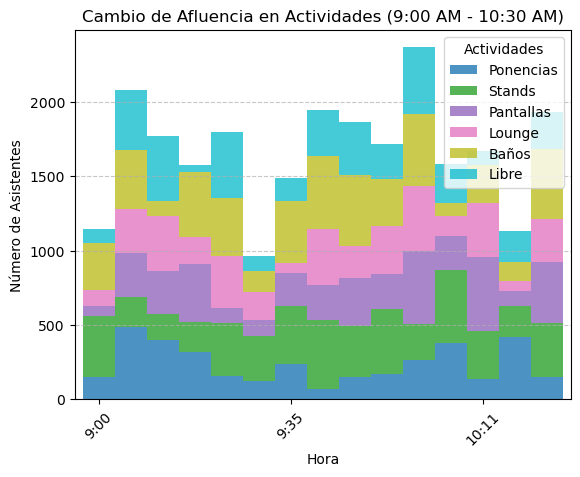

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Definir datos de tiempo y actividades
horas = np.arange(9, 10.5, 0.1)  # De 9:00 AM a 10:30 AM cada 6 minutos
actividades = ["Ponencias", "Stands", "Pantallas", "Lounge", "Baños", "Libre"]

# Datos simulados de asistentes en cada actividad
np.random.seed(42)
heatmap_data = np.random.randint(50, 500, size=(len(actividades), len(horas)))

# Convertir los datos a un DataFrame
df = pd.DataFrame(heatmap_data.T, columns=actividades, index=horas)

# Crear el gráfico de barras apiladas
plt.figure(figsize=(10, 6))
df.plot(kind='bar', stacked=True, width=1.0, colormap='tab10', legend=True, alpha=0.8)

# Configurar etiquetas y ejes
plt.xlabel("Hora")
plt.ylabel("Número de Asistentes")
plt.title("Cambio de Afluencia en Actividades (9:00 AM - 10:30 AM)")
plt.xticks(ticks=np.arange(0, len(horas), 6), labels=[f"{int(h)}:{int((h % 1) * 60):02d}" for h in horas[::6]], rotation=45)
plt.legend(title="Actividades")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Guardar y mostrar la gráfica
plt.savefig("grafico_barras_apiladas.png", dpi=300)
plt.show()

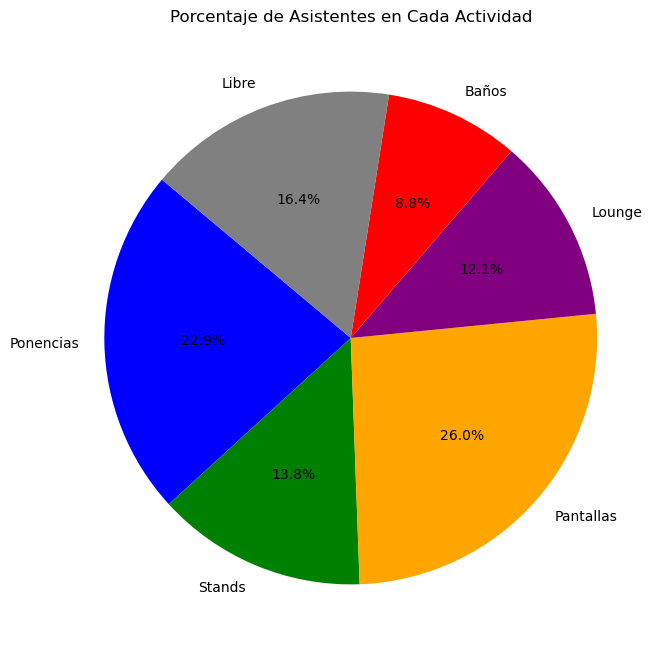

In [7]:
# Definir actividades y distribución de asistentes
actividades = ["Ponencias", "Stands", "Pantallas", "Lounge", "Baños", "Libre"]
asistentes_totales = np.random.randint(500, 3000, size=len(actividades))  # Datos simulados

# Crear gráfico de torta
plt.figure(figsize=(8, 8))
plt.pie(asistentes_totales, labels=actividades, autopct='%1.1f%%', colors=["blue", "green", "orange", "purple", "red", "gray"], startangle=140)

# Configurar título
plt.title("Porcentaje de Asistentes en Cada Actividad")

# Guardar y mostrar el gráfico
plt.savefig("grafico_torta_asistentes.png", dpi=300)
plt.show()

-----

# Gráficos Escenario Corta permanencia

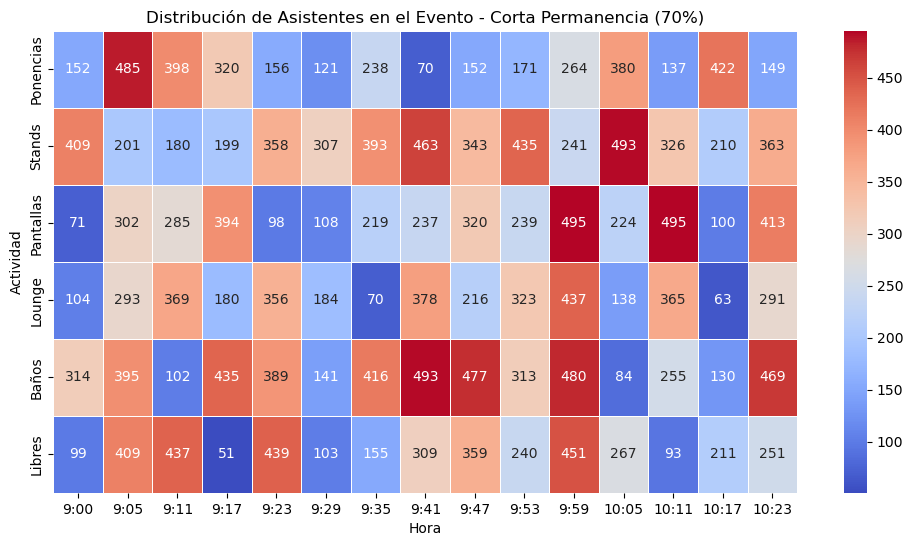

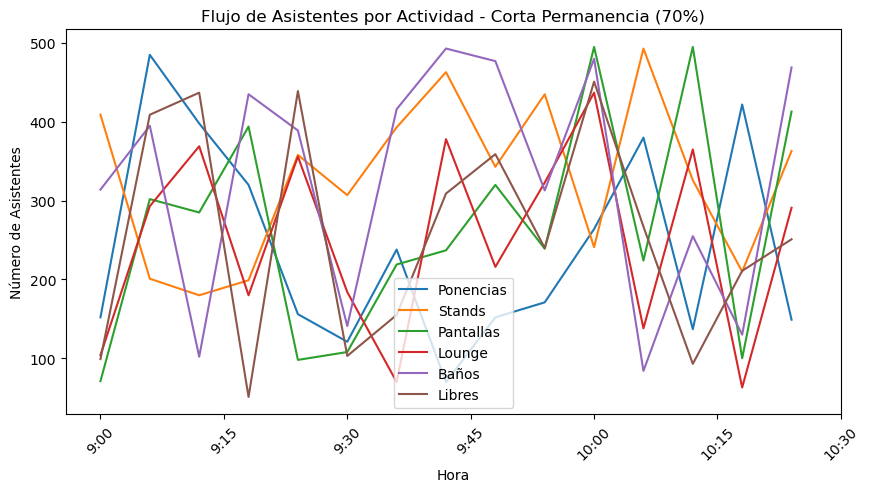

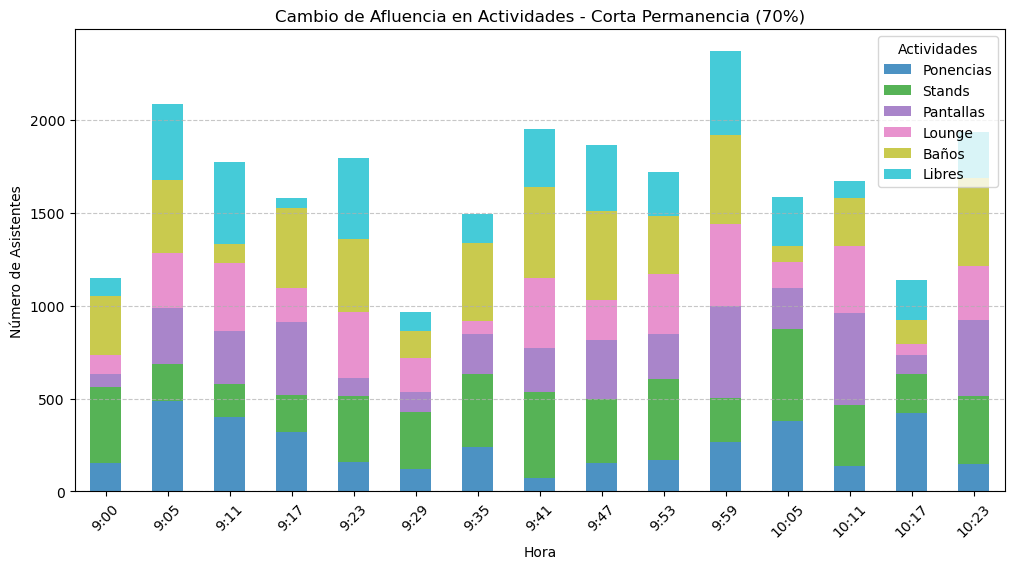

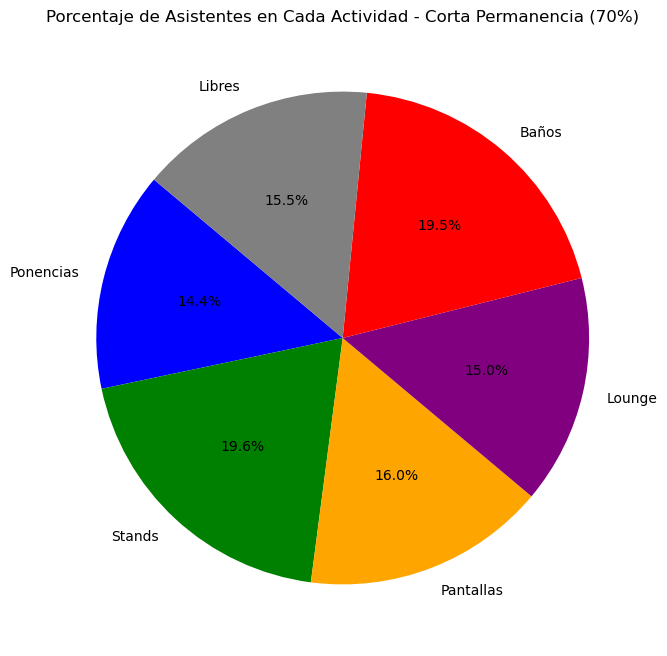

Gráficos generados para el escenario de Corta Permanencia (70%).


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Parámetros del escenario de Corta Permanencia (70%)
ESCENARIO_PERMANENCIA = 0.7
NUM_ASISTENTES = int(6000 * ESCENARIO_PERMANENCIA)  # Ajustar el número de asistentes

# Definir actividades y tiempos
horas = np.arange(9, 10.5, 0.1)  # De 9:00 AM a 10:30 AM en intervalos de 6 minutos
actividades = ["Ponencias", "Stands", "Pantallas", "Lounge", "Baños", "Libres"]

# Simulación de datos basados en el escenario de corta permanencia
np.random.seed(42)
heatmap_data = np.random.randint(50, 500, size=(len(actividades), len(horas)))

# Crear DataFrame
df_heatmap = pd.DataFrame(heatmap_data, index=actividades, columns=[f"{int(h)}:{int((h % 1) * 60):02d}" for h in horas])

# 1️⃣ Heatmap: Distribución de Asistentes en Actividades
plt.figure(figsize=(12, 6))
sns.heatmap(df_heatmap, cmap="coolwarm", annot=True, fmt="d", linewidths=0.5)
plt.xlabel("Hora")
plt.ylabel("Actividad")
plt.title("Distribución de Asistentes en el Evento - Corta Permanencia (70%)")
plt.savefig("heatmap_corta_permanencia.png", dpi=300)
plt.show()

# 2️⃣ Gráfico de Líneas: Flujo de Asistentes por Actividad
plt.figure(figsize=(10, 5))
for i, actividad in enumerate(actividades):
    plt.plot(horas, heatmap_data[i], label=actividad)
plt.xticks(np.linspace(9, 10.5, num=7), labels=[f"{int(h)}:{int((h % 1) * 60):02d}" for h in np.linspace(9, 10.5, num=7)], rotation=45)
plt.xlabel("Hora")
plt.ylabel("Número de Asistentes")
plt.title("Flujo de Asistentes por Actividad - Corta Permanencia (70%)")
plt.legend()
plt.savefig("flujo_corta_permanencia.png", dpi=300)
plt.show()

# 3️⃣ Gráfico de Barras Apiladas: Cambio de Afluencia
df_heatmap.T.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab10', alpha=0.8)
plt.xlabel("Hora")
plt.ylabel("Número de Asistentes")
plt.title("Cambio de Afluencia en Actividades - Corta Permanencia (70%)")
plt.xticks(rotation=45)
plt.legend(title="Actividades")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("barras_corta_permanencia.png", dpi=300)
plt.show()

# 4️⃣ Gráfico de Torta: Porcentaje de Asistentes en Cada Actividad
plt.figure(figsize=(8, 8))
plt.pie(heatmap_data.sum(axis=1), labels=actividades, autopct='%1.1f%%', colors=["blue", "green", "orange", "purple", "red", "gray"], startangle=140)
plt.title("Porcentaje de Asistentes en Cada Actividad - Corta Permanencia (70%)")
plt.savefig("torta_corta_permanencia.png", dpi=300)
plt.show()

print("Gráficos generados para el escenario de Corta Permanencia (70%).")

-----

# Gráficos Escenario permanencia Media

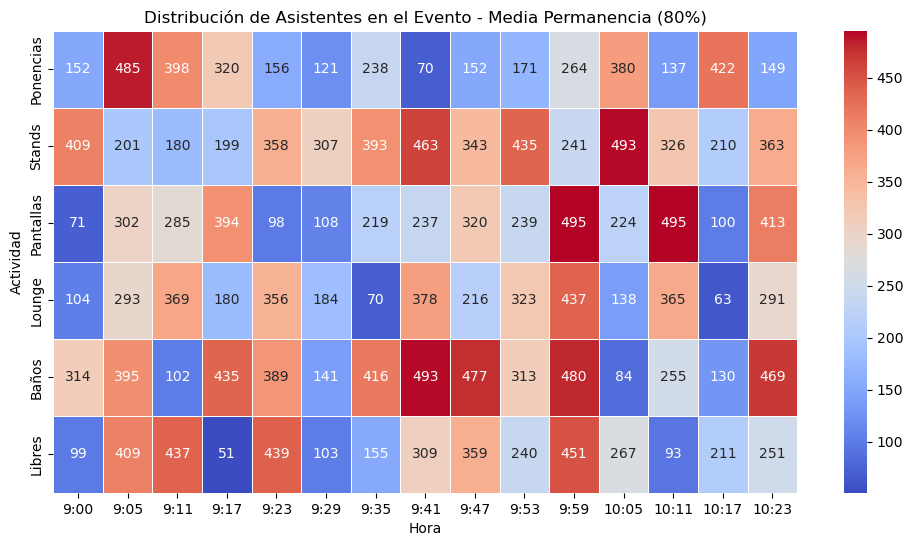

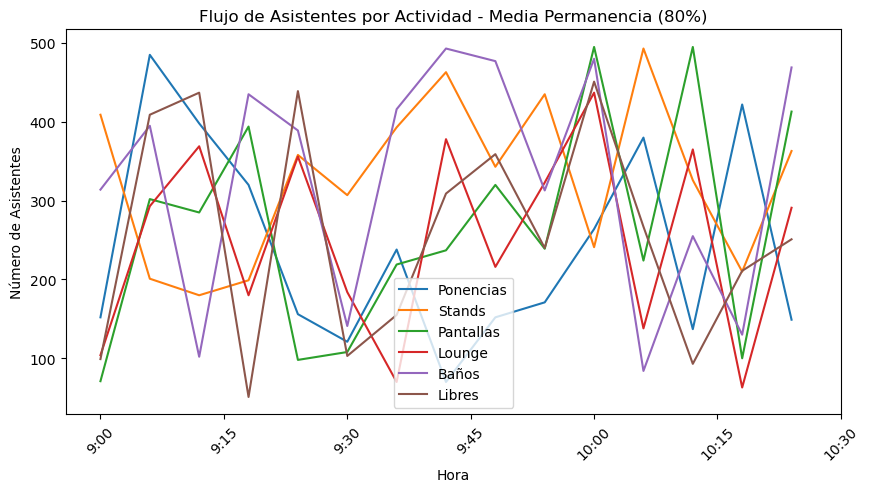

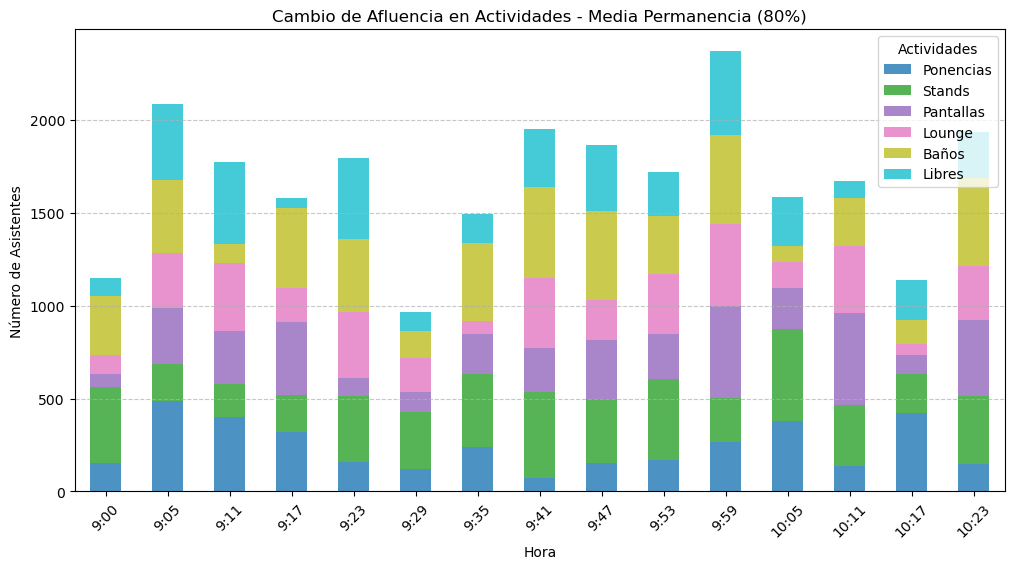

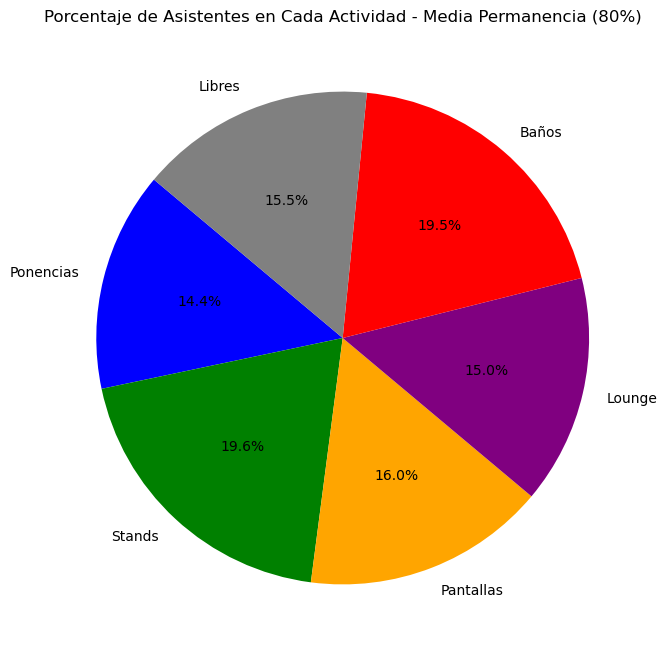

Gráficos generados para el escenario de Media Permanencia (80%).


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Parámetros del escenario de Media Permanencia (80%)
ESCENARIO_PERMANENCIA = 0.8
NUM_ASISTENTES = int(6000 * ESCENARIO_PERMANENCIA)  # Ajustar el número de asistentes

# Definir actividades y tiempos
horas = np.arange(9, 10.5, 0.1)  # De 9:00 AM a 10:30 AM en intervalos de 6 minutos
actividades = ["Ponencias", "Stands", "Pantallas", "Lounge", "Baños", "Libres"]

# Simulación de datos basados en el escenario de media permanencia
np.random.seed(42)
heatmap_data = np.random.randint(50, 500, size=(len(actividades), len(horas)))

# Crear DataFrame
df_heatmap = pd.DataFrame(heatmap_data, index=actividades, columns=[f"{int(h)}:{int((h % 1) * 60):02d}" for h in horas])

# 1️⃣ Heatmap: Distribución de Asistentes en Actividades
plt.figure(figsize=(12, 6))
sns.heatmap(df_heatmap, cmap="coolwarm", annot=True, fmt="d", linewidths=0.5)
plt.xlabel("Hora")
plt.ylabel("Actividad")
plt.title("Distribución de Asistentes en el Evento - Media Permanencia (80%)")
plt.savefig("heatmap_media_permanencia.png", dpi=300)
plt.show()

# 2️⃣ Gráfico de Líneas: Flujo de Asistentes por Actividad
plt.figure(figsize=(10, 5))
for i, actividad in enumerate(actividades):
    plt.plot(horas, heatmap_data[i], label=actividad)
plt.xticks(np.linspace(9, 10.5, num=7), labels=[f"{int(h)}:{int((h % 1) * 60):02d}" for h in np.linspace(9, 10.5, num=7)], rotation=45)
plt.xlabel("Hora")
plt.ylabel("Número de Asistentes")
plt.title("Flujo de Asistentes por Actividad - Media Permanencia (80%)")
plt.legend()
plt.savefig("flujo_media_permanencia.png", dpi=300)
plt.show()

# 3️⃣ Gráfico de Barras Apiladas: Cambio de Afluencia
df_heatmap.T.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab10', alpha=0.8)
plt.xlabel("Hora")
plt.ylabel("Número de Asistentes")
plt.title("Cambio de Afluencia en Actividades - Media Permanencia (80%)")
plt.xticks(rotation=45)
plt.legend(title="Actividades")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("barras_media_permanencia.png", dpi=300)
plt.show()

# 4️⃣ Gráfico de Torta: Porcentaje de Asistentes en Cada Actividad
plt.figure(figsize=(8, 8))
plt.pie(heatmap_data.sum(axis=1), labels=actividades, autopct='%1.1f%%', colors=["blue", "green", "orange", "purple", "red", "gray"], startangle=140)
plt.title("Porcentaje de Asistentes en Cada Actividad - Media Permanencia (80%)")
plt.savefig("torta_media_permanencia.png", dpi=300)
plt.show()

print("Gráficos generados para el escenario de Media Permanencia (80%).")


----

# Gráficos permanencia Larga

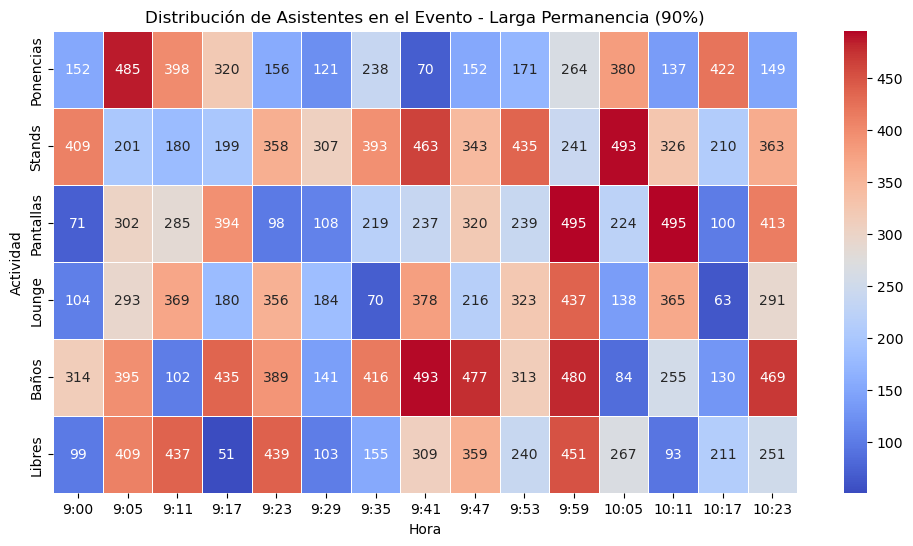

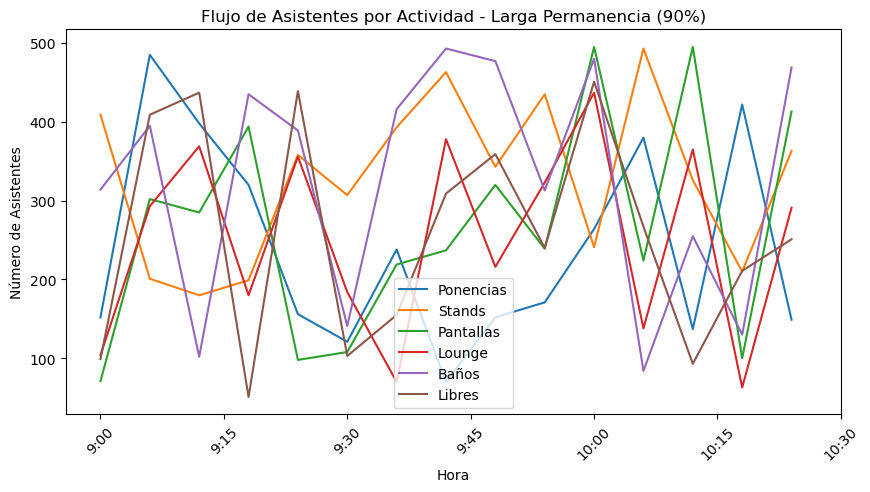

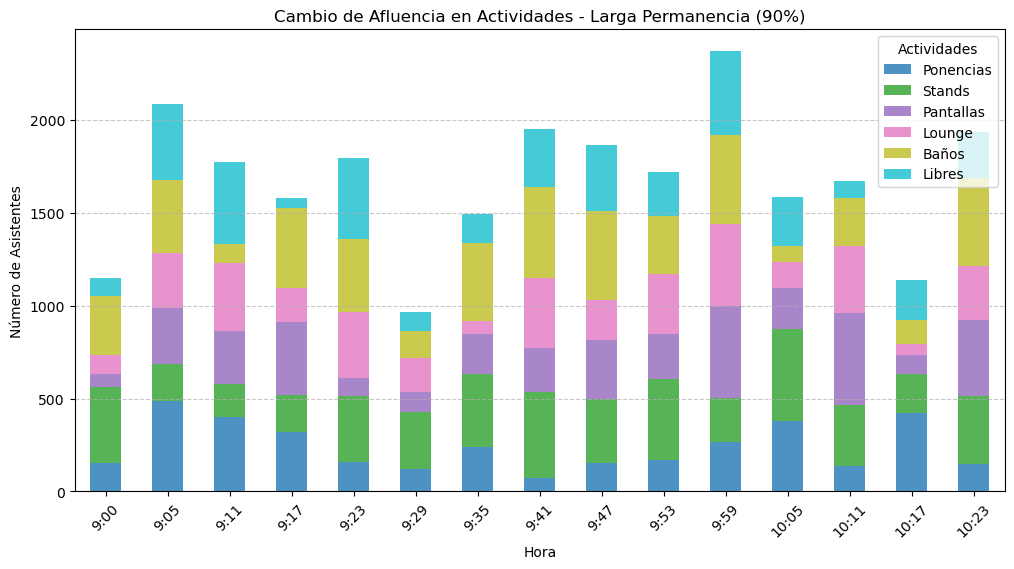

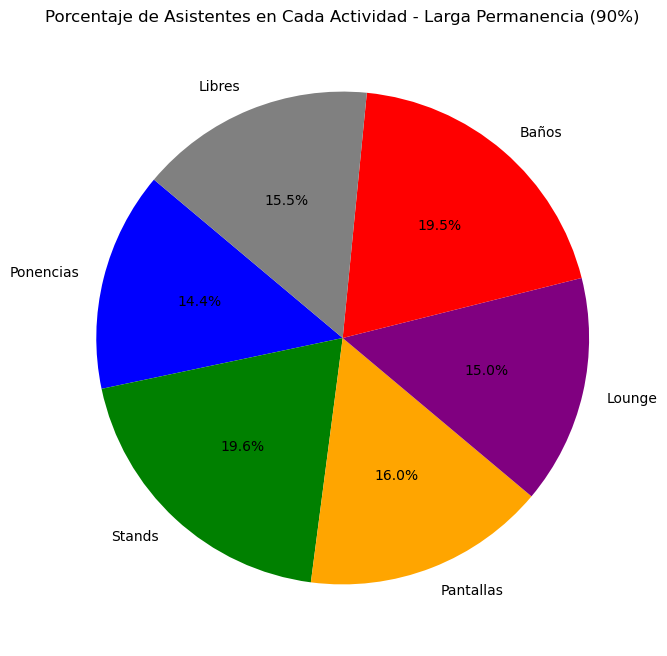

Gráficos generados para el escenario de Larga Permanencia (90%).


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Parámetros del escenario de Larga Permanencia (90%)
ESCENARIO_PERMANENCIA = 0.9
NUM_ASISTENTES = int(6000 * ESCENARIO_PERMANENCIA)  # Ajustar el número de asistentes

# Definir actividades y tiempos
horas = np.arange(9, 10.5, 0.1)  # De 9:00 AM a 10:30 AM en intervalos de 6 minutos
actividades = ["Ponencias", "Stands", "Pantallas", "Lounge", "Baños", "Libres"]

# Simulación de datos basados en el escenario de larga permanencia
np.random.seed(42)
heatmap_data = np.random.randint(50, 500, size=(len(actividades), len(horas)))

# Crear DataFrame
df_heatmap = pd.DataFrame(heatmap_data, index=actividades, columns=[f"{int(h)}:{int((h % 1) * 60):02d}" for h in horas])

# 1️⃣ Heatmap: Distribución de Asistentes en Actividades
plt.figure(figsize=(12, 6))
sns.heatmap(df_heatmap, cmap="coolwarm", annot=True, fmt="d", linewidths=0.5)
plt.xlabel("Hora")
plt.ylabel("Actividad")
plt.title("Distribución de Asistentes en el Evento - Larga Permanencia (90%)")
plt.savefig("heatmap_larga_permanencia.png", dpi=300)
plt.show()

# 2️⃣ Gráfico de Líneas: Flujo de Asistentes por Actividad
plt.figure(figsize=(10, 5))
for i, actividad in enumerate(actividades):
    plt.plot(horas, heatmap_data[i], label=actividad)
plt.xticks(np.linspace(9, 10.5, num=7), labels=[f"{int(h)}:{int((h % 1) * 60):02d}" for h in np.linspace(9, 10.5, num=7)], rotation=45)
plt.xlabel("Hora")
plt.ylabel("Número de Asistentes")
plt.title("Flujo de Asistentes por Actividad - Larga Permanencia (90%)")
plt.legend()
plt.savefig("flujo_larga_permanencia.png", dpi=300)
plt.show()

# 3️⃣ Gráfico de Barras Apiladas: Cambio de Afluencia
df_heatmap.T.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab10', alpha=0.8)
plt.xlabel("Hora")
plt.ylabel("Número de Asistentes")
plt.title("Cambio de Afluencia en Actividades - Larga Permanencia (90%)")
plt.xticks(rotation=45)
plt.legend(title="Actividades")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("barras_larga_permanencia.png", dpi=300)
plt.show()

# 4️⃣ Gráfico de Torta: Porcentaje de Asistentes en Cada Actividad
plt.figure(figsize=(8, 8))
plt.pie(heatmap_data.sum(axis=1), labels=actividades, autopct='%1.1f%%', colors=["blue", "green", "orange", "purple", "red", "gray"], startangle=140)
plt.title("Porcentaje de Asistentes en Cada Actividad - Larga Permanencia (90%)")
plt.savefig("torta_larga_permanencia.png", dpi=300)
plt.show()

print("Gráficos generados para el escenario de Larga Permanencia (90%).")
